In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_ENABLE_ONEDNN_OPTS'] =  "0"



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2024-06-06 20:23:30.353743: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 20:23:30.353773: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 20:23:30.357434: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-06 20:23:30.699986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0


In [2]:
## Uso de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2024-06-06 20:23:34.978438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 20:23:35.039655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 20:23:35.039822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Datos

In [3]:
## Obtener todas las rutas de las imágenes en el dataset
ruta = '../Datasets/Micrografías_segmentadas/secas/*/*/*/*.jpg'
rutas_dataset  = glob.glob('../../../Datasets/Micrografías segmentaciones/secas/*/*/*/*.jpg')

## Separar rutas
mask_list = []
image_list = []
for ruta in rutas_dataset:    
    ruta_list = ruta.split('/')       
    clase = ruta_list[6]
    number = ruta_list[7]
    tipo = ruta_list[8]
    name = ruta_list[9].split('.')[0]
    
    if tipo == 'train':
        image_list.append([name,ruta,clase,number])
    elif tipo == 'mask_bin':
        mask_list.append([name,ruta,clase,number])
    else:
        None

mask_pd = pd.DataFrame(mask_list,columns=['name','route_mask','label','number']).sort_values(by='name')
image_pd = pd.DataFrame(image_list,columns=['name','route_image','label','number']).sort_values(by='name')

routes_dataset = image_pd.merge(mask_pd,on=['name','label','number'],how='left')

routes_dataset.dropna(inplace=True)

routes_dataset = routes_dataset.sample(frac = 1)

print('Imágenes secas:', np.shape(routes_dataset)[0])
print('MF1:', np.shape(routes_dataset[routes_dataset['label']=='MF1'])[0])
print('MF2:', np.shape(routes_dataset[routes_dataset['label']=='MF2'])[0])
print('MF3:', np.shape(routes_dataset[routes_dataset['label']=='MF3'])[0])

char_to_num = {'MF1':'0','MF2':'1','MF3':'2'}

routes_dataset['label'].replace(char_to_num,inplace=True)

routes_dataset

Imágenes secas: 923
MF1: 378
MF2: 284
MF3: 261


,name,route_image,label,number,route_mask
885,IMG_20230711_215101_jpg,../../../Datasets/Micrografías segmentaciones/...,2,6,../../../Datasets/Micrografías segmentaciones/...
322,IMG_20230707_180434_jpg,../../../Datasets/Micrografías segmentaciones/...,0,5,../../../Datasets/Micrografías segmentaciones/...
226,IMG_20230707_170921_jpg,../../../Datasets/Micrografías segmentaciones/...,0,3,../../../Datasets/Micrografías segmentaciones/...
759,IMG_20230711_182826_jpg,../../../Datasets/Micrografías segmentaciones/...,1,7,../../../Datasets/Micrografías segmentaciones/...
369,IMG_20230707_184517_jpg,../../../Datasets/Micrografías segmentaciones/...,0,6,../../../Datasets/Micrografías segmentaciones/...
...,...,...,...,...,...
769,IMG_20230711_210714_jpg,../../../Datasets/Micrografías segmentaciones/...,2,2,../../../Datasets/Micrografías segmentaciones/...
268,IMG_20230707_173628_jpg,../../../Datasets/Micrografías segmentaciones/...,0,4,../../../Datasets/Micrografías segmentaciones/...
241,IMG_20230707_171125_jpg,../../../Datasets/Micrografías segmentaciones/...,0,3,../../../Datasets/Micrografías segmentaciones/...
361,IMG_20230707_180957_jpg,../../../Datasets/Micrografías segmentaciones/...,0,5,../../../Datasets/Micrografías segmentaciones/...


In [4]:
## Establecer el porcentaje de separación
thold1 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='0'])))
thold2 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='1'])))
thold3 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='2'])))

## Separar por clases para entrenamiento
train_cu1 = routes_dataset[routes_dataset.label == '0'][0:thold1]
train_cu2 = routes_dataset[routes_dataset.label == '1'][0:thold2]
train_cu3 = routes_dataset[routes_dataset.label == '2'][0:thold3]

## tomar las demás imágenes para test
test_cu1 = routes_dataset[routes_dataset.label == '0'][thold1:]
test_cu2 = routes_dataset[routes_dataset.label == '1'][thold2:]
test_cu3 = routes_dataset[routes_dataset.label == '2'][thold3:]


## Constuir un solo dataset de training
train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3]).sample(frac=1,random_state=42).reset_index(drop=True)

## Construir un solo dataset de test
test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3]).sample(frac=1,random_state=100).reset_index(drop=True)

## Cantidad de muestras por clase
print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

Clase MF1: train:  303 , test:  75
Clase MF2: train:  228 , test:  56
Clase MF3: train:  209 , test:  52


In [5]:
## Function to get contours and features
def get_contours_and_features(binary_map):
    #https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html
    binary_map = cv2.cvtColor(binary_map, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_features = []
    for contour in contours:
        error = 1e-5
        moments = cv2.moments(contour)
        cx = moments['m10'] / (moments['m00'] + error)
        cy = moments['m01'] / (moments['m00'] + error)
        center_of_mass = [cx, cy]
        x,y,w,h = cv2.boundingRect(contour)        
        rect_area = w*h
        features = {
            'bounding_box': (x,y,w,h),
            'area': cv2.contourArea(contour),
            'perimeter': cv2.arcLength(contour, True),       
            #'solidity': np.float32(cv2.contourArea(contour))/cv2.convexHull(contour),
            'equivalent_diameter': np.sqrt(4*cv2.contourArea(contour)/np.pi),            
            'moments': moments,
            'center_of_mass': center_of_mass,
            'contour': contour
        }
        contours_features.append(features)
        del features
    #plt.imshow(contours_map, cmap='gray')
    return contours_features

# function to get a determined property from a list of contours features (area by default)
def get_item(contour_features, key='area'):
    areas = []
    for contour_feature in contour_features:
        area =  contour_feature[key]
        areas.append(area)
    return areas

# function to get tensor of one image
def load_image(file_name):
  raw = tf.io.read_file(file_name)
  tensor = tf.io.decode_jpeg(raw,channels=1)
  tensor = tf.image.resize(tensor, [128,128])
  tensor = tf.cast(tensor, tf.float32) / 255.0
  return tensor

# function to get set of binary image from image loaded
def get_binary_image(filenames):
    tensores = []
    for filename in filenames:
        raw = tf.io.read_file(filename)
        tensor = tf.io.decode_jpeg(raw,channels=3)
        tensor = tf.image.resize(tensor, [128,128])
        tensor = tf.cast(tensor, tf.float32) / 255.0
        tensores.append(tensor)
    return tensores

def get_geometric_atributes(binary_images):
    descriptors = []
    for binary_img in binary_images:
        ## Formato
        image = binary_img.numpy().astype(np.uint8)       
        
        ## Capturar contornos
        contour_features = get_contours_and_features(image)
        
        ## Calcular vector de áreas de poro (todos los poros)
        areas = get_item(contour_features, key='area')

        ## Calcular vector de perímetros de poro (todo los poros)
        pmtro = get_item(contour_features, key='perimeter')

        ## Calcular el diametro equivalente de los poros
        eq_diameter = get_item(contour_features, key='equivalent_diameter')           

        ## Número de poros
        npores = np.shape(areas)[0]

        descriptor = [np.mean(areas), np.mean(pmtro),np.mean(eq_diameter), npores]
        
        descriptors.append(descriptor)
        
    
    return descriptors

def create_dataset(buffer,file_names, labels, file_mask): 
  ## Get binary images   
  masks = get_binary_image(file_mask)
  ## Get geometric atributes from binary images
  attributes = get_geometric_atributes(masks)
  ## Create dataset from tensors assosiated with labels and attributes
  dataset = tf.data.Dataset.from_tensor_slices((file_names,labels,attributes))
  ## Shuffle dataset
  dataset.shuffle(buffer_size=buffer)
  ## Map dataset to load images (a = image, b = label, c = attributes, d = mask)
  dataset = dataset.map(lambda file_name, label, attributes : (load_image(file_name), label, attributes))

  return dataset

### Dataset entrenamiento
file_names = train_df['route_image'].to_numpy()
file_mask = train_df['route_mask'].to_numpy()
labels = train_df['label'].to_numpy()
## Create training dataset using tf.data of 16 images
dataset = create_dataset(16,file_names, labels,file_mask)

### Dataset test
file_names = test_df['route_image'].to_numpy()
file_mask = test_df['route_mask'].to_numpy()
labels = test_df['label'].to_numpy()
## Create test dataset using tf.data of 16 images
dataset_test = create_dataset(16,file_names, labels,file_mask) 

2024-06-06 20:23:36.416776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 20:23:36.416960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 20:23:36.417070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[213.          60.64654328  15.43612334  31.        ]
0


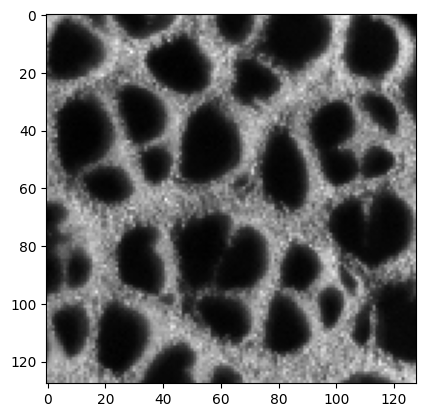

In [9]:
cnt = 0
for i in dataset.batch(16):
    a = i[0]
    b = i[1]
    c = i[2]
    #d = i[3]

n =  0
print(c[n].numpy())
#imprimir solo el valor numérico del tensor sin la b
print(int(b[n].numpy()))
plt.imshow(a[n],cmap='gray')
#plt.imshow(d[n],cmap='gray')
plt.show()

In [10]:
## Crear np.array con las imágenes y sus features
# Test
X_test = []
y_test_class = []
y_test_mean_pore_area = []
y_test_mean_pore_pmtr = []
y_test_mean_pore_eq_diameter = []
y_test_n_pores = []

for i in dataset_test:
    ## cargar imágenes para introducir al modelo
    X_test.append(i[0].numpy())
    y_test_class.append(int(i[1].numpy()))
    ## extraer propiedades una a una 
    y_test_mean_pore_area.append(i[2][0].numpy())
    y_test_mean_pore_pmtr.append(i[2][1].numpy())
    y_test_mean_pore_eq_diameter.append(i[2][2].numpy())
    y_test_n_pores.append(i[2][3].numpy())
    

X_test = np.array(X_test).astype(np.float32)
y_test_class = np.array(y_test_class)
y_test_mean_pore_area = np.array(y_test_mean_pore_area)
y_test_mean_pore_pmtr = np.array(y_test_mean_pore_pmtr)
y_test_mean_pore_eq_diameter = np.array(y_test_mean_pore_eq_diameter)
y_test_n_pores = np.array(y_test_n_pores)

# Train
X_train = []
y_train_class = []
y_train_mean_pore_area = []
y_train_mean_pore_pmtr = []
y_train_mean_pore_eq_diameter = []
y_train_n_pores = []


for i in dataset:
    X_train.append(i[0].numpy())
    y_train_class.append(str(int(i[1].numpy())))
    ## extraer propiedades una a una 
    y_train_mean_pore_area.append(i[2][0].numpy())
    y_train_mean_pore_pmtr.append(i[2][1].numpy())
    y_train_mean_pore_eq_diameter.append(i[2][2].numpy())
    y_train_n_pores.append(i[2][3].numpy())

X_train = np.array(X_train).astype(np.float32)
y_train_class = np.array(y_train_class)
y_train_mean_pore_area = np.array(y_train_mean_pore_area)
y_train_mean_pore_pmtr = np.array(y_train_mean_pore_pmtr)
y_train_mean_pore_eq_diameter = np.array(y_train_mean_pore_eq_diameter)
y_train_n_pores = np.array(y_train_n_pores)

    
print(np.shape(X_train))    

(740, 128, 128, 1)


# Modelo

In [11]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [12]:
encoder = keras.models.load_model('Models2/weakly_GVAE_encoder_DRY_1_16.h5', custom_objects={'Sampling':Sampling})
decoder = keras.models.load_model('Models2/weakly_GVAE_decoder_DRY_1_16.h5', custom_objects={'Sampling':Sampling})

2024-06-06 20:30:52.919078: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.


# Properties over latent space

## Generar embebidos

In [13]:
## Media = 0, Varianza = 1, Z = 2
D = 2

## Dimensiones
dmx = 8
dmy = 4

In [14]:
## Data train and test
data_train = X_train
data_test = X_test

## Labels
label_train = y_train_class
label_test = y_test_class

print('Train: ',np.shape(data_train),np.shape(label_train))
print('Test: ',np.shape(data_test),np.shape(label_test))

# Embebidos del encoder
encoder_embds  = encoder.predict(data_train)
print('Shape_embs: ',np.shape(encoder_embds))

# Embebidos del encoder
encoder_embds_test  = encoder.predict(data_test)
print('Shape_embs: ',np.shape(encoder_embds_test))

Train:  (740, 128, 128, 1) (740,)
Test:  (183, 128, 128, 1) (183,)


2024-06-06 20:30:55.791604: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48496640 exceeds 10% of free system memory.
2024-06-06 20:30:55.863566: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48496640 exceeds 10% of free system memory.
2024-06-06 20:30:56.253319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-06-06 20:30:56.893310: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-06 20:30:56.894158: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available

24/24 [==============================] - 5s 90ms/step
Shape_embs:  (3, 740, 16)
6/6 [==============================] - 1s 241ms/step
Shape_embs:  (3, 183, 16)


### PCA

In [15]:
pca_data_test = PCA(n_components=2)
PCA_2dim_test = pca_data_test.fit_transform(encoder_embds_test[D])
PCA_2dim_test.shape

(183, 2)

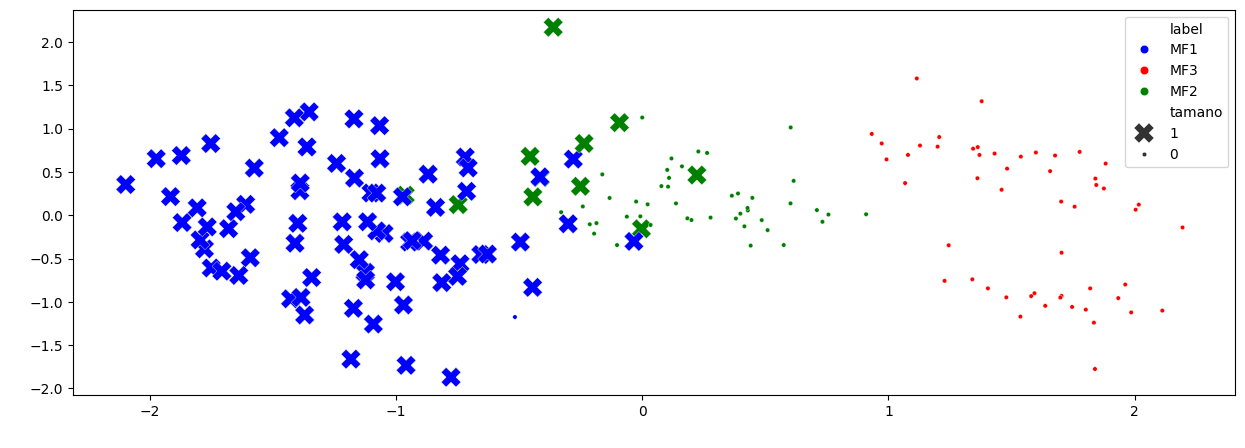

In [16]:
## graph pca embbedings regarding labels
labels_text_test = pd.DataFrame(label_test).replace({0: "MF1", 1: "MF2",2: "MF3"})
labels_text_test.shape

data_img_pca_test = pd.DataFrame()                 
data_img_pca_test['x'] = PCA_2dim_test[:,0]
data_img_pca_test['y'] = PCA_2dim_test[:,1]
data_img_pca_test['label'] = pd.DataFrame(labels_text_test)
data_img_pca_test['area'] = y_test_mean_pore_area
data_img_pca_test['perimetro'] = y_test_mean_pore_pmtr
data_img_pca_test['eq_diameter'] = y_test_mean_pore_eq_diameter
data_img_pca_test['poros'] = y_test_n_pores

## crear una columna que categorice los poros por tamaño de 1 a 5
data_img_pca_test['tamano'] = data_img_pca_test['area'].apply(lambda x: 1 if x > np.mean(y_test_mean_pore_area) else 0)


sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='label',data=data_img_pca_test,
                style='tamano',
                alpha=1, palette={"MF3": "red", "MF2": "green", "MF1": "blue"},
                legend=True, size='tamano',sizes=(10, 200),size_order=[1,0])
plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()

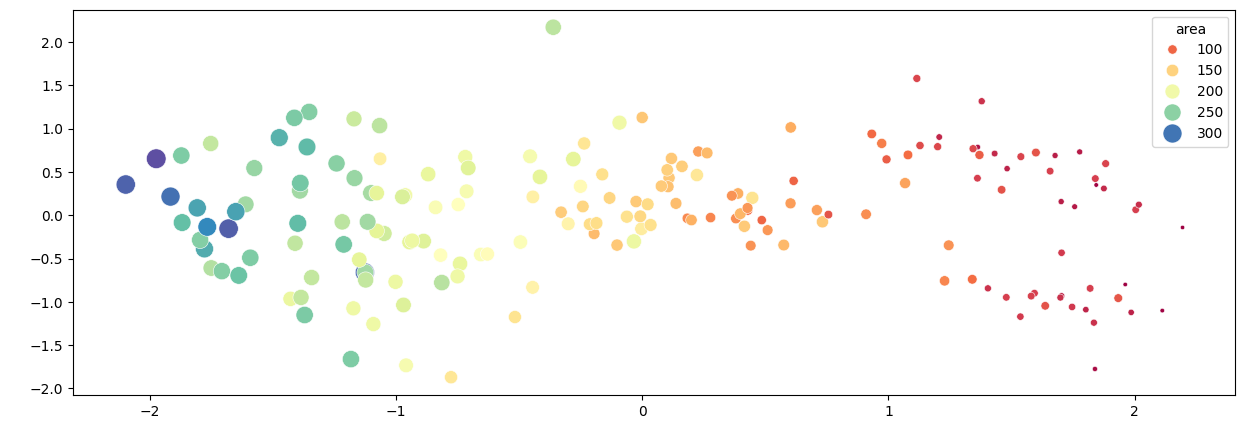

In [21]:
## graph pca embeddings regarding pore area
import matplotlib.cm as cm
sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='area',data=data_img_pca_test, 
                alpha=1, palette= "Spectral",size='area',sizes=(10, 200),size_order=[1,0])

## Set colobar
#data_color = pore_area_test
#min = np.min(data_color)
#max = np.max(data_color)
#plt.colorbar(cm.ScalarMappable(cmap=plt.jet()),label='Pore area',orientation='vertical', ax=plt.gca())

plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()


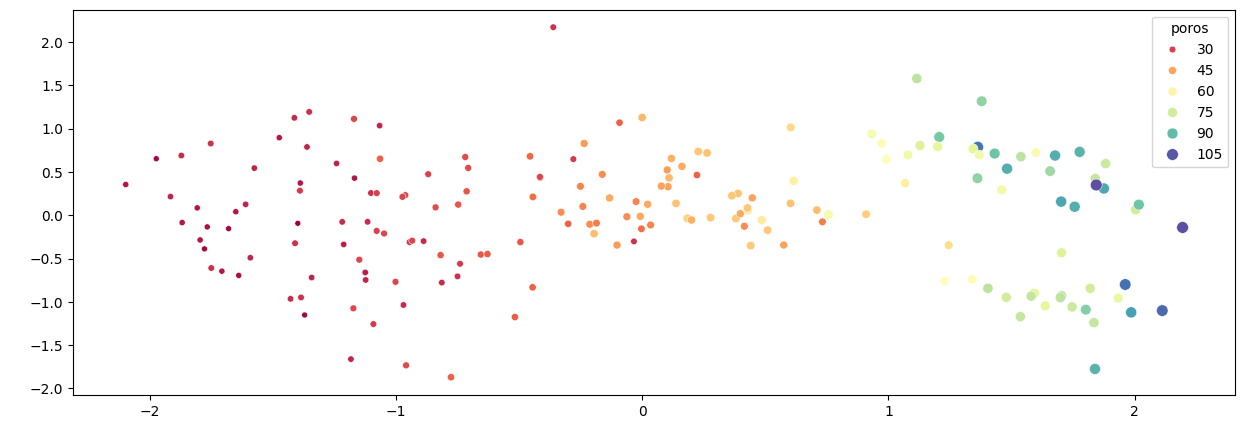

In [20]:
## graph pca embeddings regarding pore area
import matplotlib.cm as cm
sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='poros',data=data_img_pca_test, 
                alpha=1, palette="Spectral",size='poros')


plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()

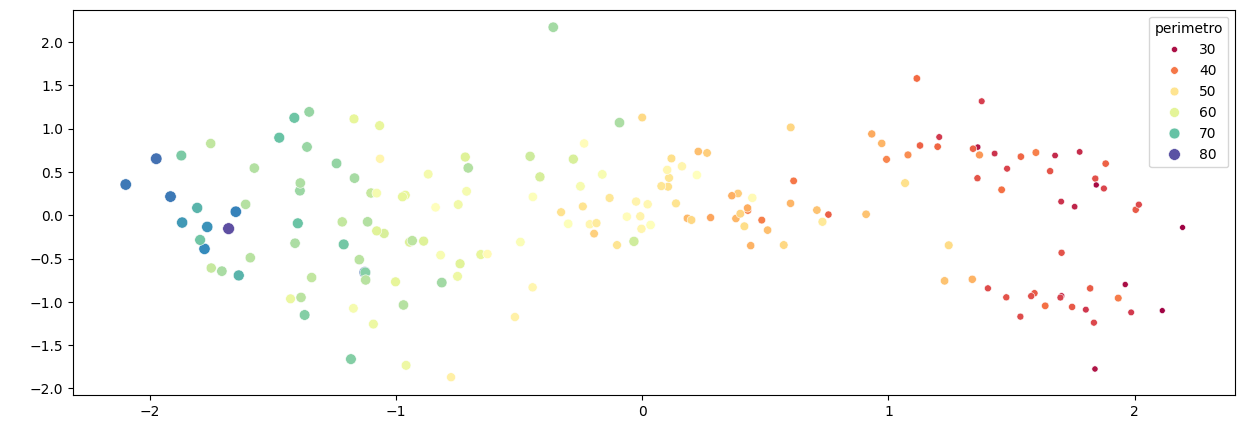

In [22]:
## graph pca embeddings regarding pore area
import matplotlib.cm as cm
sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='perimetro',data=data_img_pca_test, 
                alpha=1, palette="Spectral",size='perimetro')


plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()

## Validación estadística de las propiedades de poro

In [26]:
## cargar regresor
regressor = keras.models.load_model('Models2/weakly_GVAE_regressor_DRY_1_16.h5')

In [65]:
## capturar embeddings de test and pore properties
embs = encoder_embds_test[D]
poros = y_test_n_pores
areas = y_test_mean_pore_area
perimetros = y_test_mean_pore_pmtr
diametros = y_test_mean_pore_eq_diameter

## generar reconstrucciones con embs
reconstructions = decoder.predict(embs)

## generar propiedades de los poros from reconstructions
predicted_features = regressor.predict(reconstructions)

## calcular diferencias MSE, RMSE, MAE

predicted_features = np.squeeze(regressor.predict(reconstructions))

## metrics for pore area (MSE, RMSE, MAE, L1)
mse = tf.keras.losses.mean_squared_error(areas,predicted_features[0,:])
rmse = tf.math.sqrt(mse)
mae = tf.keras.losses.mean_absolute_error(areas,predicted_features[0,:])
l1 = tf.keras.losses.mean_absolute_error(areas,predicted_features[0,:])
print("Pore area") 
print('MSE: ',mse.numpy())
print('RMSE: ',rmse.numpy())
print('MAE: ',mae.numpy())
print('L1: ',l1.numpy())


## metrics for pore perimeter (MSE, RMSE, MAE, L1)
mse = tf.keras.losses.mean_squared_error(perimetros,predicted_features[1,:])
rmse = tf.math.sqrt(mse)
mae = tf.keras.losses.mean_absolute_error(perimetros,predicted_features[1,:])
l1 = tf.keras.losses.mean_absolute_error(perimetros,predicted_features[1,:])

print("Pore perimeter")
print('MSE: ',mse.numpy())
print('RMSE: ',rmse.numpy())
print('MAE: ',mae.numpy())
print('L1: ',l1.numpy())

## metrics for pore equivalent diameter (MSE, RMSE, MAE, L1)
mse = tf.keras.losses.mean_squared_error(diametros,predicted_features[2,:])
rmse = tf.math.sqrt(mse)
mae = tf.keras.losses.mean_absolute_error(diametros,predicted_features[2,:])
l1 = tf.keras.losses.mean_absolute_error(diametros,predicted_features[2,:])

print("Pore equivalent diameter")
print('MSE: ',mse.numpy())
print('RMSE: ',rmse.numpy())
print('MAE: ',mae.numpy())
print('L1: ',l1.numpy())

## metrics for pore number (MSE, RMSE, MAE, L1)
mse = tf.keras.losses.mean_squared_error(poros,predicted_features[3,:])
rmse = tf.math.sqrt(mse)
mae = tf.keras.losses.mean_absolute_error(poros,predicted_features[3,:])
l1 = tf.keras.losses.mean_absolute_error(poros,predicted_features[3,:])

print("Pore number")
print('MSE: ',mse.numpy())
print('RMSE: ',rmse.numpy())
print('MAE: ',mae.numpy())
print('L1: ',l1.numpy())



6/6 [==============================] - 0s 3ms/step
Pore area
MSE:  13619.727
RMSE:  116.70358
MAE:  101.982475
L1:  101.982475
Pore perimeter
MSE:  77.54335
RMSE:  8.80587
MAE:  7.791945
L1:  7.791945
Pore equivalent diameter
MSE:  2269.2615
RMSE:  47.63677
MAE:  46.484978
L1:  46.484978
Pore number
MSE:  1336.1202
RMSE:  36.55298
MAE:  31.730677
L1:  31.730677
